# Homework 10 - CIFAR10 Image Classification with PyTorch

## About

The goal of the homework is to train a convolutional neural network on the standard CIFAR10 image classfication dataset.

When solving machine learning tasks using neural networks, one typically starts with a simple network architecture and then improves the network by adding new layers, retraining, adjusting parameters, retraining, etc.  We attempt to illustrate this process below with several architecture improvements.


## Dev Environment
### Working on Google Colab
You may choose to work locally or on Google Colaboratory. You have access to free compute through this service.   Colab is recommended since it will be setup correctly and will have access to GPU resources.
1. Visit https://colab.research.google.com/drive 
2. Navigate to the **`Upload`** tab, and upload your `HW10.ipynb`
3. Now on the top right corner, under the `Comment` and `Share` options, you should see a `Connect` option. Once you are connected, you will have access to a VM with 12GB RAM, 50 GB disk space and a single GPU. The dropdown menu will allow you to connect to a local runtime as well.

**Notes:** 
* **If you do not have a working setup for Python 3, this is your best bet. It will also save you from heavy installations like `tensorflow` if you don't want to deal with those.**
* ***There is a downside*. You can only use this instance for a single 12-hour stretch, after which your data will be deleted, and you would have redownload all your datasets, any libraries not already on the VM, and regenerate your logs**.


### Installing PyTorch and Dependencies

The instructions for installing and setting up PyTorch can be found at https://pytorch.org/get-started/locally/. Make sure you follow the instructions for your machine. For any of the remaining libraries used in this assignment:
* We have provided a `hw8_requirements.txt` file on the homework web page. 
* Download this file, and in the same directory you can run `pip3 install -r hw8_requirements.txt`
​
Check that PyTorch installed correctly by running the following:

In [44]:
import torch
torch.rand(5, 3)

tensor([[0.6529, 0.8300, 0.3982],
        [0.7574, 0.3594, 0.1487],
        [0.6654, 0.7324, 0.2646],
        [0.7374, 0.7814, 0.9135],
        [0.2481, 0.2306, 0.9768]])

## Part 0 Imports and Basic Setup  (5 Points)

First, import the required libraries as follows. The libraries we will use will be the same as those in HW8. 

In [0]:
import numpy as np
import torch
from torch import nn
from torch import optim

import matplotlib.pyplot as plt

**GPU Support**

Training of large network can take a long time. PyTorch supports GPU with just a small amount of effort.

When creating our networks, we will call 
`net.to(device)` to tell the network to train on the GPU, if one is available.  Note, if the network utilizes the GPU, it is important that any tensors we use with it (such as the data) also reside on the CPU.  Thus, a call like `images = images.to(device)` is necessary with any data we want to use with the GPU.

Note: If you can't get access to a GPU, don't worry to much.  Since we use very small networks, the difference between CPU and GPU isn't large and in some cases GPU will actually be slower.

In [46]:
import torch.cuda as cuda

# Use a GPU, i.e. cuda:0 device if it available.
device = torch.device("cuda:0" if cuda.is_available() else "cpu")
print(device)

cuda:0


### Training Code

In [0]:
import time

class Flatten(nn.Module):
  """NN Module that flattens the incoming tensor."""
  def forward(self, input):
    return input.view(input.size(0), -1)
  
def train(model, train_loader, test_loader, loss_func, opt, num_epochs=10):
  all_training_loss = np.zeros((0,2))
  all_training_acc = np.zeros((0,2))
  all_test_loss = np.zeros((0,2))
  all_test_acc = np.zeros((0,2))
  
  training_step = 0
  training_loss, training_acc = 2.0, 0.0
  print_every = 1000
  
  start = time.clock()
  
  for i in range(num_epochs):
    epoch_start = time.clock() 
   
    model.train()
    for images, labels in train_loader:
      images, labels = images.to(device), labels.to(device)
      opt.zero_grad()

      preds = model(images)
      loss = loss_func(preds, labels)
      loss.backward()
      opt.step()
      
      training_loss += loss.item()
      training_acc += (torch.argmax(preds, dim=1)==labels).float().mean()
      
      if training_step % print_every == 0:
        training_loss /= print_every
        training_acc /= print_every
        
        all_training_loss = np.concatenate((all_training_loss, [[training_step, training_loss]]))
        all_training_acc = np.concatenate((all_training_acc, [[training_step, training_acc]]))
        
        print('  Epoch %d @ step %d: Train Loss: %3f, Train Accuracy: %3f' % (
            i, training_step, training_loss, training_acc))
        training_loss, training_acc = 0.0, 0.0
        
      training_step+=1

    model.eval()
    with torch.no_grad():
      validation_loss, validation_acc = 0.0, 0.0
      count = 0
      for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        validation_loss+=loss_func(output,labels)
        validation_acc+=(torch.argmax(output, dim=1) == labels).float().mean()
        count += 1
      validation_loss/=count
      validation_acc/=count
      
      all_test_loss = np.concatenate((all_test_loss, [[training_step, validation_loss]]))
      all_test_acc = np.concatenate((all_test_acc, [[training_step, validation_acc]]))
      
      epoch_time = time.clock() - epoch_start
      
      print('Epoch %d Test Loss: %3f, Test Accuracy: %3f, time: %.1fs' % (
          i, validation_loss, validation_acc, epoch_time))
      
  total_time = time.clock() - start
  print('Final Test Loss: %3f, Test Accuracy: %3f, Total time: %.1fs' % (
      validation_loss, validation_acc, total_time))

  return {'loss': { 'train': all_training_loss, 'test': all_test_loss },
          'accuracy': { 'train': all_training_acc, 'test': all_test_acc }}

def plot_graphs(model_name, metrics):
  for metric, values in metrics.items():
    for name, v in values.items():
      plt.plot(v[:,0], v[:,1], label=name)
    plt.title(f'{metric} for {model_name}')
    plt.legend()
    plt.xlabel("Training Steps")
    plt.ylabel(metric)
    plt.show()
    

Load the** CIFA-10** dataset and define the transformations. You may also want to print its structure, size, as well as sample a few images to get a sense of how to design the network. 

In [47]:
!mkdir hw10_data

mkdir: cannot create directory ‘hw10_data’: File exists


In [48]:
# Download the data.
from torchvision import datasets, transforms

transformations = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_set = datasets.CIFAR10(root='hw10_data/', download=True, transform=transformations)
test_set = datasets.CIFAR10(root='hw10_data', download=True, train=False, transform=transformations)

Files already downloaded and verified
Files already downloaded and verified


Use `DataLoader` to create a loader for the training set and a loader for the testing set. You can use a `batch_size` of 8 to start, and change it if you wish.

In [0]:
from torch.utils.data import DataLoader

batch_size = 256 #8
train_loader = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size, shuffle=True, num_workers=2)

input_shape = np.array(train_set[0][0]).shape
input_dim = input_shape[1]*input_shape[2]*input_shape[0]


In [0]:
training_epochs = 25

## Part 1 CIFAR10 with Fully Connected Neural Netowrk (25 Points)

As a warm-up, let's begin by training a two-layer fully connected neural network model on ** CIFAR-10** dataset. You may go back to check HW8 for some basics.

We will give you this code to use as a baseline to compare against your CNN models.

In [51]:
class TwoLayerModel(nn.Module):
  def __init__(self):
    super(TwoLayerModel, self).__init__()
    self.net = nn.Sequential(
      Flatten(), 
      nn.Linear(input_dim, 64), 
      nn.ReLU(), 
      nn.Linear(64, 10))
    
  def forward(self, x):
    return self.net(x)

model = TwoLayerModel().to(device)

loss = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001, weight_decay=0.01)

# Training epoch should be about 15-20 sec each on GPU.
metrics = train(model, train_loader, test_loader, loss, optimizer, training_epochs)

  Epoch 0 @ step 0: Train Loss: 0.004295, Train Accuracy: 0.000113
Epoch 0 Test Loss: 1.799146, Test Accuracy: 0.364551, time: 1.2s
Epoch 1 Test Loss: 1.717270, Test Accuracy: 0.380859, time: 1.3s
Epoch 2 Test Loss: 1.603553, Test Accuracy: 0.427051, time: 1.3s
Epoch 3 Test Loss: 1.658042, Test Accuracy: 0.418457, time: 1.2s
Epoch 4 Test Loss: 1.598114, Test Accuracy: 0.434277, time: 1.2s
  Epoch 5 @ step 1000: Train Loss: 1.620169, Train Accuracy: 0.432607
Epoch 5 Test Loss: 1.552316, Test Accuracy: 0.462598, time: 1.2s
Epoch 6 Test Loss: 1.611885, Test Accuracy: 0.426367, time: 1.2s
Epoch 7 Test Loss: 1.580764, Test Accuracy: 0.444141, time: 1.2s
Epoch 8 Test Loss: 1.697376, Test Accuracy: 0.410938, time: 1.2s
Epoch 9 Test Loss: 1.579937, Test Accuracy: 0.442578, time: 1.2s
  Epoch 10 @ step 2000: Train Loss: 1.526308, Train Accuracy: 0.463935
Epoch 10 Test Loss: 1.559898, Test Accuracy: 0.449414, time: 1.2s
Epoch 11 Test Loss: 1.529849, Test Accuracy: 0.450781, time: 1.3s
Epoch 12 T

**Plot the model results**

Normally we would want to use Tensorboard for looking at metrics.  However, if colab reset while we are working, we might lose our logs and therefore our metrics.  Let's just plot some graphs that will survive across colab instances.

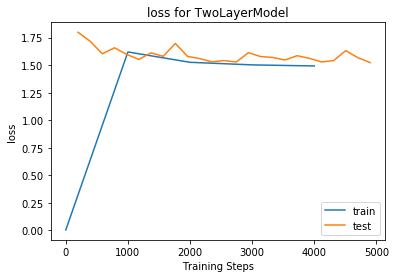

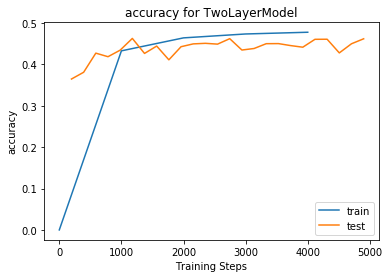

In [52]:
plot_graphs("TwoLayerModel", metrics)

## Part 2 Convolutional Neural Network (CNN) (35 Points)

Now, let's design a convolution neural netwrok!

Build a simple CNN model, inserting 2 CNN layers in from of our 2 layer fully connect model from above:

1. A convolution with	3x3 filter, 16 output channels, stride = 1, padding=1
2. A ReLU activation
2. A Max-Pooling layer with 2x2 window
3. A convolution,	3x3 filter, 16 output channels, stride = 1, padding=1
4. A ReLU activation
4. Flatten layer
5. Fully connected linear layer with output size 64
6. ReLU
7. Fully connected linear layer, with output size 10

You will have to figure out the input sizes of the first fully connnected layer based on the previous layer sizes. Note that you also need to fill those in the report section (see report section in the notebook for details) 

In [53]:
class ConvModel(nn.Module):
    def __init__(self):
        super(ConvModel, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=16, kernel_size=3, stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=1),
            nn.Conv2d(in_channels=16,out_channels=16, kernel_size=3, stride=1,padding=1),
            nn.ReLU(),
            Flatten(),
            nn.Linear(31*31*16, 64),
            nn.ReLU(),
            nn.Linear(64, 10),
        )
        
    def forward(self, x):
        return self.net(x)

model = ConvModel().to(device)


loss = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001, weight_decay=0.01)

metrics = train(model, train_loader, test_loader, loss, optimizer, training_epochs)

  Epoch 0 @ step 0: Train Loss: 0.004304, Train Accuracy: 0.000102
Epoch 0 Test Loss: 1.766978, Test Accuracy: 0.368066, time: 2.7s
Epoch 1 Test Loss: 1.538963, Test Accuracy: 0.437109, time: 2.7s
Epoch 2 Test Loss: 1.448862, Test Accuracy: 0.465039, time: 3.0s
Epoch 3 Test Loss: 1.580119, Test Accuracy: 0.447266, time: 2.7s
Epoch 4 Test Loss: 1.570375, Test Accuracy: 0.423828, time: 2.9s
  Epoch 5 @ step 1000: Train Loss: 1.505343, Train Accuracy: 0.459505
Epoch 5 Test Loss: 1.365523, Test Accuracy: 0.495508, time: 2.8s
Epoch 6 Test Loss: 1.293404, Test Accuracy: 0.526953, time: 2.7s
Epoch 7 Test Loss: 1.293109, Test Accuracy: 0.529004, time: 2.7s
Epoch 8 Test Loss: 1.343846, Test Accuracy: 0.501660, time: 2.7s
Epoch 9 Test Loss: 1.282475, Test Accuracy: 0.534375, time: 2.8s
  Epoch 10 @ step 2000: Train Loss: 1.260061, Train Accuracy: 0.549146
Epoch 10 Test Loss: 1.232488, Test Accuracy: 0.557422, time: 2.6s
Epoch 11 Test Loss: 1.208673, Test Accuracy: 0.572949, time: 2.6s
Epoch 12 T

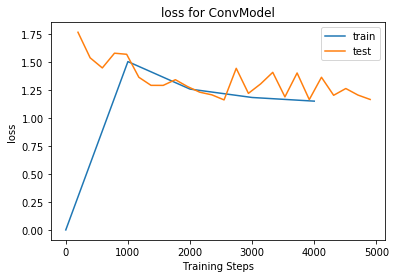

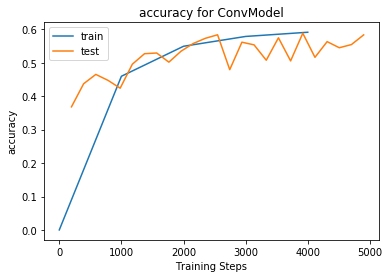

In [54]:
plot_graphs("ConvModel", metrics)

Do you notice the improvement over the accuracy compared to that in Part 1?

## Part 3 Open Design Competition (35 Points + 10 bonus points)

Try to beat the previous models by adding additional layers, changing parameters, etc.  You should add at least one layer.

Possible changes include:
*   Dropout
*   Batch Normalization
*   More layers
*   Residual Connections (harder)
*   Change layer size
*   Pooling layers, stride
*   Different optimizer
*   Train for longer

Once you have a model you think is great, evaluate it against our hidden test data (see hidden_loader above) and upload the results to the leader board on gradescope.  **The top 3 scorers will get a bonus 10 points.**

You can steal model structures found on the internet if you want.  The only constraint is that **you must train the model from scratch**.


In [55]:
# You Awesome Super Best model code here
class AwesomeModel(nn.Module):
    def __init__(self):
        super(AwesomeModel, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=32, kernel_size=3, stride=1,padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            
            nn.Conv2d(in_channels=32,out_channels=32, kernel_size=3, stride=1,padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Dropout2d(0.2),
            
            nn.Conv2d(in_channels=32,out_channels=64, kernel_size=3, stride=1,padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64,out_channels=64, kernel_size=3, stride=1,padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Dropout2d(0.3),
            
            nn.Conv2d(in_channels=64,out_channels=128, kernel_size=3, stride=1,padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128,out_channels=128, kernel_size=3, stride=1,padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Dropout2d(0.4),
            
            Flatten(),
            nn.Linear(128*4*4, 10)
        )
        
    def forward(self, x):
        return self.net(x)

model = AwesomeModel().to(device)

loss = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001, weight_decay=0.01)

metrics = train(model, train_loader, test_loader, loss, optimizer, training_epochs)


  Epoch 0 @ step 0: Train Loss: 0.004489, Train Accuracy: 0.000094
Epoch 0 Test Loss: 1.471441, Test Accuracy: 0.445801, time: 6.6s
Epoch 1 Test Loss: 1.105345, Test Accuracy: 0.605273, time: 6.6s
Epoch 2 Test Loss: 0.892807, Test Accuracy: 0.679492, time: 6.5s
Epoch 3 Test Loss: 0.830514, Test Accuracy: 0.711328, time: 6.5s
Epoch 4 Test Loss: 0.901177, Test Accuracy: 0.690234, time: 6.1s
  Epoch 5 @ step 1000: Train Loss: 1.067488, Train Accuracy: 0.625320
Epoch 5 Test Loss: 0.760794, Test Accuracy: 0.734961, time: 6.5s
Epoch 6 Test Loss: 0.885828, Test Accuracy: 0.688379, time: 6.5s
Epoch 7 Test Loss: 0.713735, Test Accuracy: 0.750879, time: 6.7s
Epoch 8 Test Loss: 0.808031, Test Accuracy: 0.728125, time: 6.2s
Epoch 9 Test Loss: 0.667858, Test Accuracy: 0.766504, time: 6.2s
  Epoch 10 @ step 2000: Train Loss: 0.696012, Train Accuracy: 0.759795
Epoch 10 Test Loss: 0.836739, Test Accuracy: 0.704004, time: 6.5s
Epoch 11 Test Loss: 0.644305, Test Accuracy: 0.774219, time: 6.0s
Epoch 12 T

**What changes did you make to improve your model?**

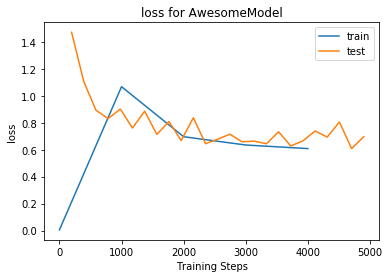

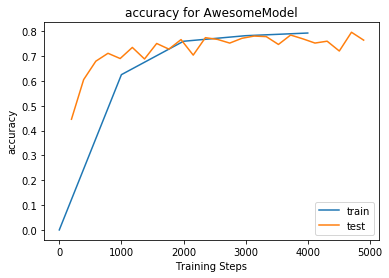

In [56]:
plot_graphs("AwesomeModel", metrics)

After you get a nice model, download the test_file.zip and unzip it to get test_file.pt. In colab, you can explore your files from the left side bar. You can also download the files to your machine from there.

In [57]:
!wget http://courses.engr.illinois.edu/cs498aml/sp2019/homeworks/test_file.zip
!unzip test_file.zip

--2019-04-30 15:37:55--  http://courses.engr.illinois.edu/cs498aml/sp2019/homeworks/test_file.zip
Resolving courses.engr.illinois.edu (courses.engr.illinois.edu)... 130.126.151.9
Connecting to courses.engr.illinois.edu (courses.engr.illinois.edu)|130.126.151.9|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://courses.engr.illinois.edu/cs498aml/sp2019/homeworks/test_file.zip [following]
--2019-04-30 15:37:55--  https://courses.engr.illinois.edu/cs498aml/sp2019/homeworks/test_file.zip
Connecting to courses.engr.illinois.edu (courses.engr.illinois.edu)|130.126.151.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3841776 (3.7M) [application/x-zip-compressed]
Saving to: ‘test_file.zip.1’

test_file.zip.1     100%[===================>]   3.66M  14.0MB/s    in 0.3s    

2019-04-30 15:37:55 (14.0 MB/s) - ‘test_file.zip.1’ saved [3841776/3841776]

Archive:  test_file.zip
replace test_file.pt? [y]es, [n]o, [A]ll, [N]one, 

Then use your model to predict the label of the test images. Fill the remaining code below, where x has two dimensions (batch_size x one image size). Remember to reshpe x accordingly before feeding it into your model. The submission.txt should contain one predicted label (0~9) each line. Submit your submission.txt to the competition in gradscope.

In [0]:
import torch.utils.data as Data

test_file = 'test_file.pt'
pred_file = 'submission.txt'
f_pred = open(pred_file,'w')
tensor = torch.load(test_file)
torch_dataset = Data.TensorDataset(tensor) 
test_loader = torch.utils.data.DataLoader(torch_dataset, batch_size, shuffle=False, num_workers=2)
for ele in test_loader:
    x = ele[0]
    x = x.to(device)
    x = x.reshape(x.shape[0],3,32,32)
    _,pred=torch.max(model(x),1)
    pred=pred.cpu().detach().numpy()
    for i in enumerate(pred):
      f_pred.write(str(i[1]))
      f_pred.write('\n')
f_pred.close()


# Report

## Part 0: Imports and Basic Setup (5 Points)
Nothing to report for this part. You will be just scored for finishing the setup.

## Part 1: Fully connected neural networks (25 Points)

**Test (on validation set) accuracy (5 Points):**0.461719

**Test loss (5 Points):**1.523372

**Training time (5 Points):**30.3s


**Plots:**

- Plot a graph of accuracy on validation set vs training steps (5 Points) - **Shown Below**
- Plot a graph of loss on validation set vs training steps (5 Points) - **Shown Below**

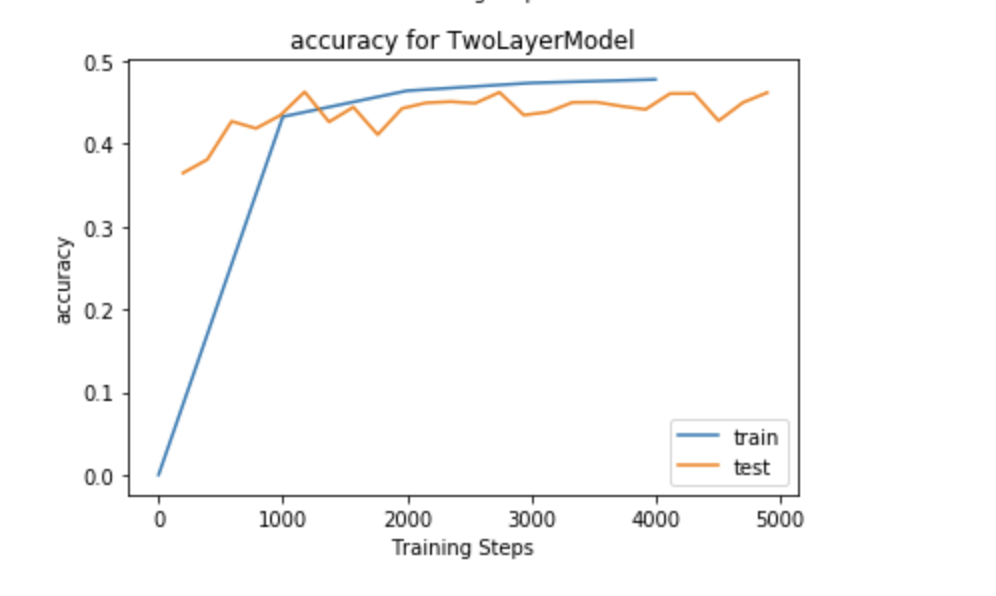

In [73]:
#Plot a graph of accuracy on validation set vs training steps (5 Points)
from IPython.display import Image
Image(filename="2layer_accuracy.png",width=600,height=400)

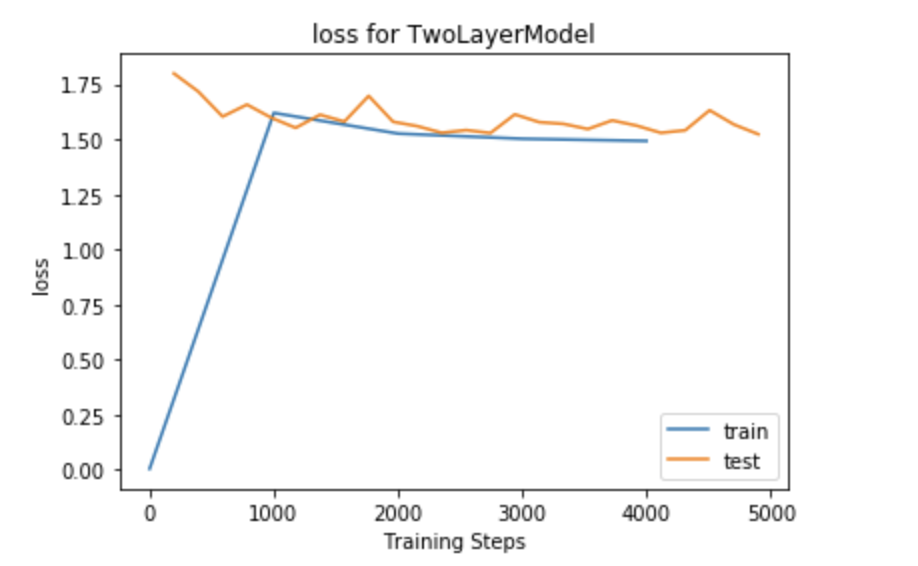

In [70]:
#Plot a graph of accuracy on validation set vs training steps (5 Points)
from IPython.display import Image
Image(filename="2layer_loss.png",width=600,height=400)


## Part 2: Convolution Network (Basic) (35 Points)

Tensor dimensions: A good way to debug your network for size mismatches is to print the dimension of output after every layers:

(10 Points)

**Output dimension after 1st conv layer:** [256, 16, 32, 32]

**Output dimension after 1st max pooling:** [256, 16, 31, 31]

**Output dimension after 2nd conv layer:** [256, 16, 31, 31]

**Output dimension after flatten layer:** [256, 15376]

**Output dimension after 1st fully connected layer: **[256, 64]

**Output dimension after 2nd fully connected layer:** [256, 10]


**Test (on validation set) Accuracy (5 Points):**0.583203

**Test loss (5 Points):**1.167589

**Training time (5 Points):**68.4s


**Plots:**

- Plot a graph of accuracy on validation set vs training steps (5 Points) - **Shown Below**
 
- Plot a graph of loss on validation set vs training steps (5 Points) - **Shown Below**

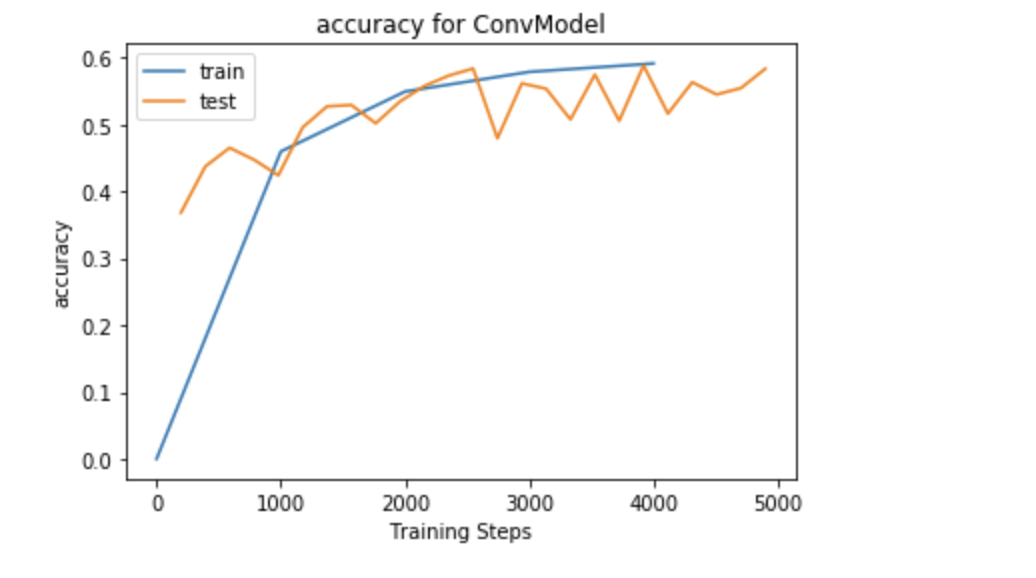

In [72]:
#Plot a graph of accuracy on validation set vs training steps (5 Points)
from IPython.display import Image
Image(filename="conv_accuracy.png",width=600,height=400)

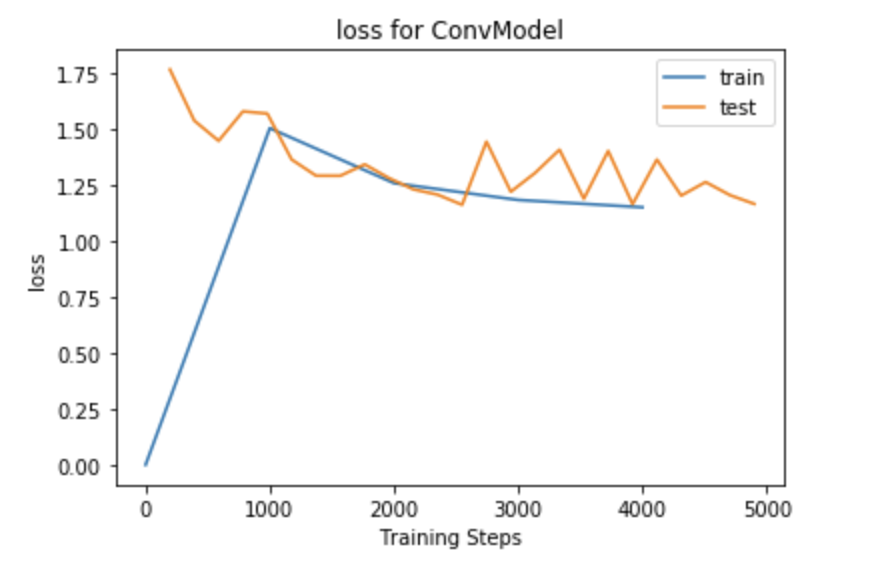

In [71]:
#Plot a graph of accuracy on validation set vs training steps (5 Points)
from IPython.display import Image
Image(filename="conv_loss.png",width=600,height=400)


## Part 3: Convolution Network (Add one or more  suggested changes) (35 Points)


Describe the additional changes implemented, your intuition for as to why it works, you may also describe other approaches you experimented with (10 Points):

Below are the addition:

**(1) Batch Normalization:**  This layer doesn't have any activation function, hence will have higher learning rate, so it will able to detect the pattern (via training), where the previous layer unable to learn it.

**(2) Drop Out Layer:** This will decrease the overfitting of the training data. Every Layer I am dropping 10% additional neuron, which also in turn remove few information from the layer. However it will benefit to remove few neurons which have influenced on the training to become overfiting.


**(3) Pooling Layer:** This will reduced the size of the dimension to half (1/2) after each pooling layer, which reduced the overall time to train the model and avoid the curse of diemsnionality 


**(4) More Layer to the Network:** More Layer being added up, hence each layer will understand/generate atleast some part of the feature (image). This will increase the accuracy of the test. Though it will not always true to increase the accuracy by adding more layer (because each layer is not learning anything new feature), however in my Aswesome model, will have 6 Layer which produce the accuracy of 78% in the Test Set


**(5) Increase the Batch Size:** Batch_size is set to 256, so for one pass to the network, it will take 256 random samples, which will increase the estimate of the gradient for each forward pass. 


**(6) Increase the number of epoch:** Since the parameters gets updates after each forward pass per batch_size(in my case its 256) till last samples is being passed, and it will gets repeated till all epochs. The larger the epoch, the longer it will train and it will reach to the global minima for more number of epoch, as the parameters gets updates on each foreward pass and per each epoch. However this will not be always true, as it could oscilates around the global minima after its reach to certain epoch and never converges to global minima. I have choose the number of epoch as 25



**Test (on validation set) Accuracy (5 Points):**0.764258

**Test loss (5 Points):**0.696222

**Training time (5 Points):**159.9s


Plots:

- Plot a graph of accuracy on validation set vs training steps (5 Points) - **Shown Below **

- Plot a graph of loss on validation set vs training steps (5 Points) - **Shown Below**

10 bonus points will be awarded to top 3 scorers on leaderboard (in case of tie for 3rd position everyone tied for 3rd position will get the bonus)

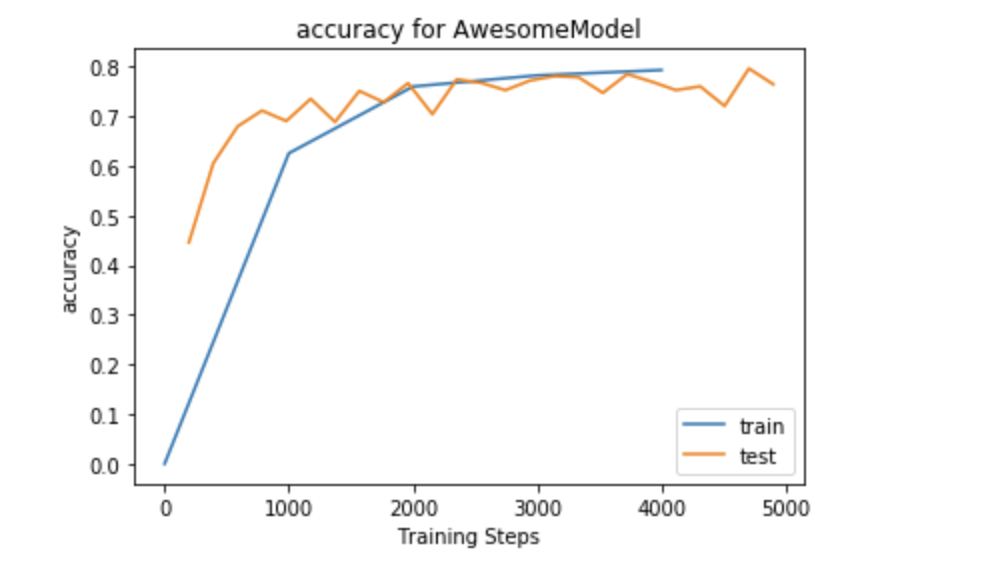

In [74]:
#Plot a graph of accuracy on validation set vs training steps (5 Points)
from IPython.display import Image
Image(filename="awesome_accuracy.png",width=600,height=400)

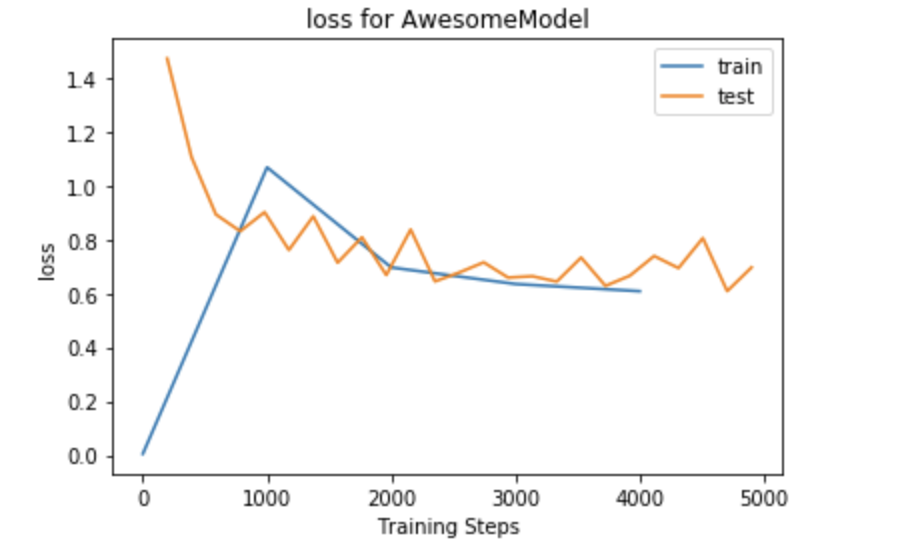

In [75]:
#Plot a graph of accuracy on validation set vs training steps (5 Points)
from IPython.display import Image
Image(filename="awesome_loss.png",width=600,height=400)